In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from joblib import Parallel, delayed
from matplotlib.backends.backend_pdf import PdfPages
from itertools import islice
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import time
from tqdm import tqdm
from matplotlib import animation
from PIL import Image
from IPython.display import HTML
import mpl_toolkits.mplot3d.axes3d as p3

from ddeint import ddeint
from scipy.integrate import quad
from scipy.integrate import RK45

In [2]:
def which_field(sep,x):
    h1,h2 = [*sep]
    above = int(h1(x)>0)
    right = int(h2(x)>0)
    if h1(x) == 0 or h2(x) == 0:
        print('h1 or h2 = 0')
    return above,right

def h1(x):
    return x[1] -x[0]
def h2(x):
    return x[0] +x[1]

def H(x):
    if x >= 0:
        return 1
    else:
        return 0

def PWS_euler(diff,sep,tstep,x0,T = 10):
    f1,f2,f3,f4 = [*diff]
    niter = int(T/tstep)
    time = np.linspace(0,T,niter)
    x = x0
    X = [x0]
    locations = [which_field(sep,x0)]
    for i in range(1,niter):
        which = which_field(sep,x)
        x = x + tstep * np.array([[f1,f2],[f3,f4]])[which]
        X += [x]
        locations += [which]
    return X, time, locations


#X = PWS_euler(diff = [np.array([0,1]),np.array([1,0]),np.array([-1,0]),np.array([0,-1])]
#    ,sep =[h1,h2], tstep = 0.1, x0=np.array([1,1]))[0]

#PWS_euler([np.array([0,1]),np.array([1,0]),np.array([0,-1]),np.array([-1,0])],[h1,h2], 0.1, np.array([1,1]))[2]


In [3]:
def PWS_euler_update(t,X,ax,ylims,xlims,clearing):

    if clearing:
        ax.clear()
        
    #have to change this manually
    h1_line = plt.Line2D([xlims[0],xlims[1]],[ylims[0],ylims[1]], color="r",alpha = 0.3)
    h2_line = plt.Line2D([xlims[0],xlims[1]],[-ylims[0],-ylims[1]], color="r",alpha = 0.3)
    h1_line.set_linestyle('--')
    h2_line.set_linestyle('--')
    ax.add_artist(h1_line)
    ax.add_artist(h2_line)
    
    ax.set_xlim(ylims)
    ax.set_ylim(xlims)    
        
        
    Xt = X[t]
    Xt1 = X[t-1]
    plot_update = ax.plot([Xt[0],Xt1[0]],[Xt[1],Xt1[1]],'b',markersize =10)

    return plot_update

In [4]:
def PWS_euler_update(t,X,ax,ylims,xlims,clearing):

    if clearing:
        ax.clear()
        
    #have to change this manually
    h1_line = plt.Line2D([xlims[0],xlims[1]],[ylims[0],ylims[1]], color="r",alpha = 0.3)
    h2_line = plt.Line2D([xlims[0],xlims[1]],[-ylims[0],-ylims[1]], color="r",alpha = 0.3)
    h1_line.set_linestyle('--')
    h2_line.set_linestyle('--')
    ax.add_artist(h1_line)
    ax.add_artist(h2_line)
    
    ax.set_xlim(ylims)
    ax.set_ylim(xlims)    
        
        
    Xt = X[t]
    Xt1 = X[t-1]
    # so right here is the jank
    plot_update = ax.plot([Xt[0],Xt1[0]],[Xt[1],Xt1[1]],'b',markersize =10)

    return plot_update

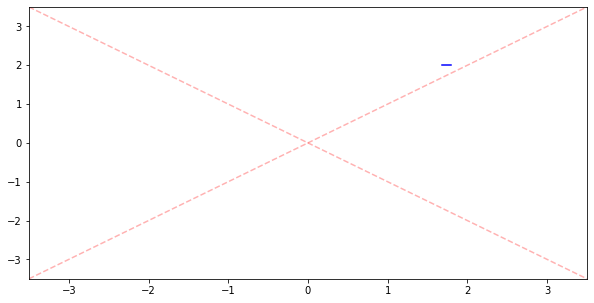

In [12]:
xlims = [-3.5,3.5]
ylims = [-3.5,3.5]
#f1,f2,f3,f4
diff = [np.array([-1,0.9]),np.array([1,0]),np.array([0,-1]),np.array([1,0])]
sep = [h1,h2]
tstep = 0.113
T = 1
x0 = np.array([1,2])

def create_anim(T,clearing = False):
    fig,ax= plt.subplots(figsize=(10,5))

    niter = int(T/tstep)
    X = PWS_euler(diff,sep,tstep = tstep,x0=x0,T=T)[0]
    
    anim = animation.FuncAnimation(fig,PWS_euler_update,fargs = [X,ax,xlims,ylims,clearing],
                                   frames = range(1,niter),interval=tstep*10**3, blit=True,repeat = True,repeat_delay = 10000)
    #fig.tight_layout()
    #anim.save("PWSeuler.gif")
    #plt.show()
    return anim

PWS_anim = create_anim(T,clearing =True)
open('PWSeuler.gif')
HTML(PWS_anim.to_html5_video())

In [6]:
def h13D(x):
    return x[0]
def h23D(x):
    return x[1]

In [7]:
def PWS_euler_update_3D(t,X,ax,clearing):

    if clearing:
        ax.clear()
        
    #have to change this manually
    #h1_line = plt.Line2D([xlims[0],xlims[1]],[ylims[0],ylims[1]], color="r",alpha = 0.3)
    #h2_line = plt.Line2D([xlims[0],xlims[1]],[-ylims[0],-ylims[1]], color="r",alpha = 0.3)
    #h1_line.set_linestyle('--')
    #h2_line.set_linestyle('--')
    #ax.add_artist(h1_line)
    #ax.add_artist(h2_line)
    xlim = 1
    ylim = 1
    zlim = 10
    
    ax.set_xlim3d([-xlim, xlim])
    ax.set_xlabel('X')

    ax.set_ylim3d([ylim, -ylim]) #note this axis is flipped so it lines up with the time proportion graphs
    ax.set_ylabel('Y')

    ax.set_zlim3d([-zlim, zlim])
    ax.set_zlabel('Z')

    ax.set_title('Euler Iterates')
    yy1, zz1 = np.meshgrid(range(-int(ylim),int(ylim)+1), range(-int(zlim),int(zlim)+1))
    xx2, zz2 = np.meshgrid(range(-int(xlim),int(xlim)+1), range(-int(zlim),int(zlim)+1))
    
    #sigma 1
    ax.plot_surface(0, yy1,zz1, alpha=0.3,color='orange')
    
    #sigma 2
    ax.plot_surface(xx2, 0,zz2, alpha=0.2,color = 'c')
    #ax.invert_yaxis()
    #ax.invert_xaxis()
        
    Xt = X[t]
    Xt1 = X[t-1]
    #jank here
    plot_update = ax.plot([Xt[0],Xt1[0]],[Xt[1],Xt1[1]],[Xt[2],Xt1[2]],'b',markersize =10)

    return plot_update

In [8]:
#f1,f2,f3,f4
diff = [np.array([1,1,2]),np.array([0,-1,0]),np.array([-1,+2,-1]),np.array([-2,0,1])]
diff = [np.array([1,1,1]),np.array([1,-1,-1]),np.array([-1,+1,-1]),np.array([-1,-1,1])]

sep = [h13D,h23D]
tstep = 0.015
T = 5

x0 = np.array([-1,1,1])
#diff = [np.array([1.,-1.,1.]),np.array([.5,-1.,0.]),np.array([-1.,+2.,-.5]),np.array([-2.,1.,1])]

#diamond
diamond = [np.array([1,-1,0]),np.array([-1,-1,0]),np.array([1,1,0]),np.array([-1,1,0])]
diamond_x0 = np.array([-1,-.01,0])
#diff = diamond
#x0 =diamond_x0 * 1.

KeyboardInterrupt: 

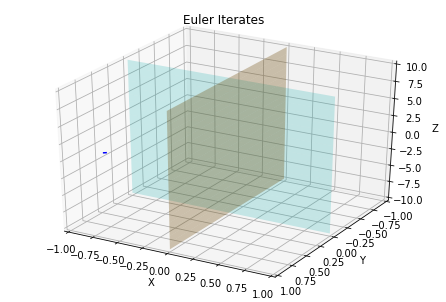

In [9]:
def create_euler_anim(T,clearing = False):
    fig = plt.figure()
    ax = p3.Axes3D(fig)

    niter = int(T/tstep)
    X = PWS_euler(diff,sep,tstep = tstep,x0=x0,T=T)[0]
        
    anim = animation.FuncAnimation(fig,PWS_euler_update_3D,fargs = [X,ax,clearing],
                                   frames = range(1,niter),interval=tstep*10**3, blit=True,repeat = True,repeat_delay = 10**10)
    #fig.tight_layout()
    #anim.save("PWSeuler.gif")
    #plt.show()

    return anim

PWS_euler_anim = create_euler_anim(T,clearing =True)

#open('PWSeuler.gif')

HTML(PWS_euler_anim.to_html5_video())


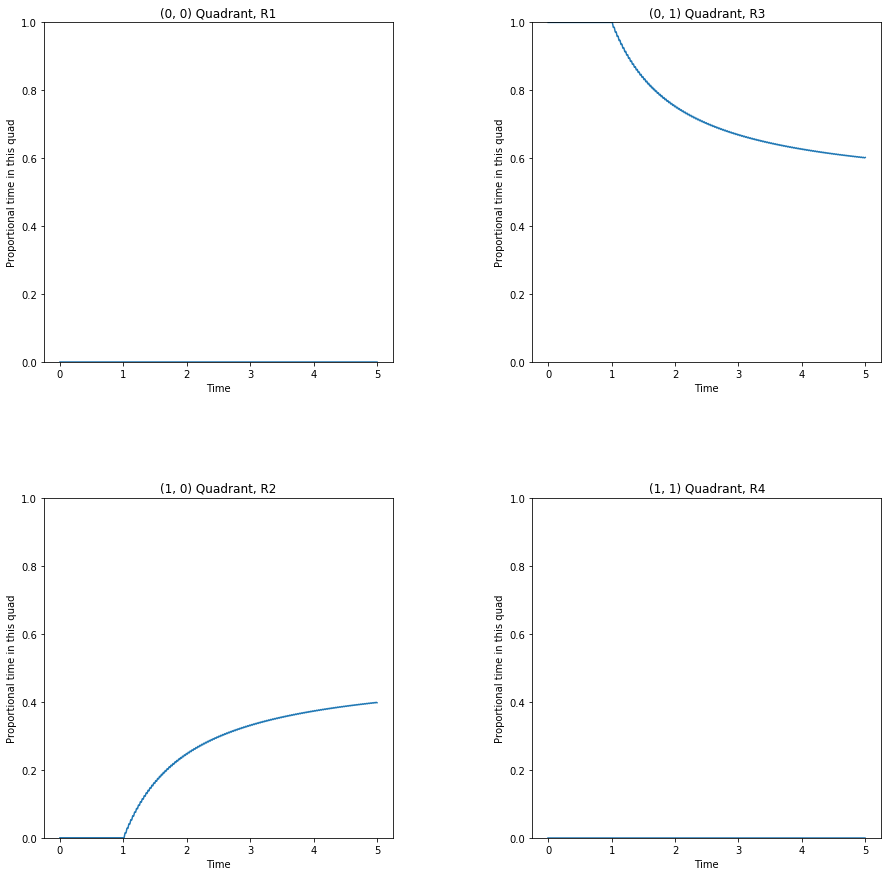

In [10]:
def prop_time(positions,cond):
    num = len(positions)
    overtime = []
    for t in range(1,num):
        focus = positions[:t].count(cond)
        overtime += [focus/t]
    return overtime
def final_prop_time(positions,cond):
    focus = positions.count(cond)
    overtime = focus/len(positions)
    return overtime

which_quad = PWS_euler(diff,sep,tstep = tstep,x0=x0,T=T)[2]

fig,axs = plt.subplots(2,2,figsize = (15,15))
for i in [0,1]:
    for j in [0,1]:
        prop = prop_time(which_quad,(i,j))
        axs[i,j].plot(np.linspace(0,T,len(prop)),prop)
        axs[i,j].set_title('{} Quadrant, R{}'.format((i,j), 1+i+2*j))
        axs[i,j].set_ylim([0,1])
        axs[i,j].set_xlabel('Time')
        axs[i,j].set_ylabel('Proportional time in this quad')
fig.subplots_adjust(hspace=0.4,wspace = 0.4)

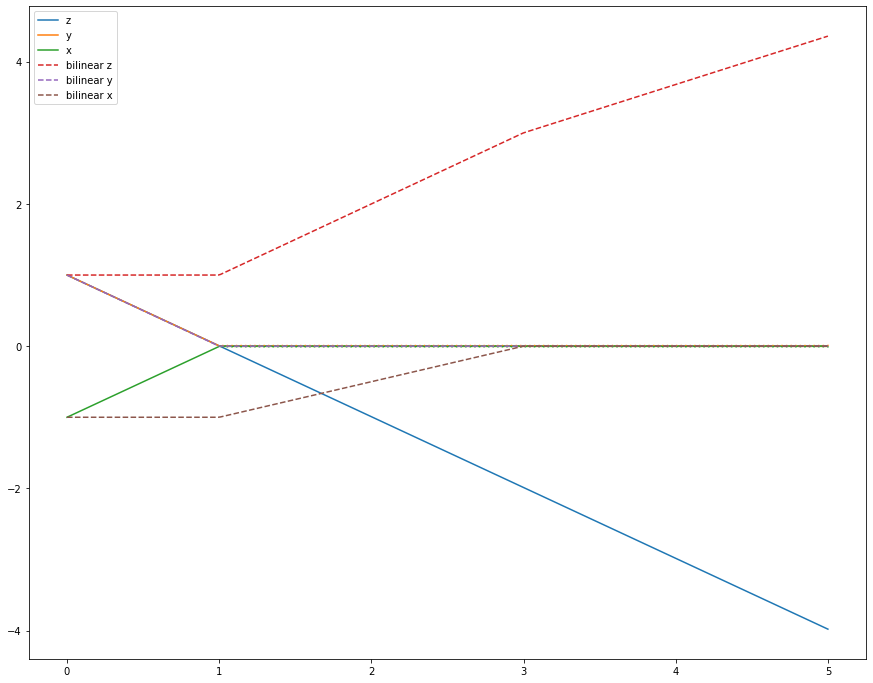

In [11]:
vals = np.array(PWS_euler(diff,sep,tstep = tstep,x0=x0,T=T)[0])
x_vals = vals[:,0]
y_vals = vals[:,1]
z_vals = vals[:,2]
plt.figure(figsize=(15,12))

plt.plot(np.linspace(0,T,len(z_vals)),z_vals,label = 'z')
plt.plot(np.linspace(0,T,len(y_vals)),y_vals,label='y')
plt.plot(np.linspace(0,T,len(x_vals)),x_vals,label='x')

def example_bilinear_solution(t):
    if 0<=t and t<1:
        return np.array([-1,1-t,1])
    elif 1<= t and t <3:
        return 0.5 * np.array([t-3,0,2*t])
    elif 3<= t:
        return 1/25 *np.array([0,0,17*t +24])
B =[]
for t in np.linspace(0,T,len(z_vals)):
    B += [example_bilinear_solution(t)]
B = np.array(B)
plt.plot(np.linspace(0,T,len(z_vals)),B[:,2],'--',label = 'bilinear z')
plt.plot(np.linspace(0,T,len(z_vals)),B[:,1],'--',label = 'bilinear y')
plt.plot(np.linspace(0,T,len(z_vals)),B[:,0],'--',label = 'bilinear x')
plt.legend(loc="upper left")


In [19]:
def quadrant_density(translation, eps=1e-5, maxiter=10*5,quadrant = 0):
    """Compute a density representing time spent in each quadrant.
    
    Args:
        translation: a list of four 2d translation vectors, where
            translation[k] represents the translation in quadrant k.
        eps: maximum l1 error before stopping
         
    Returns:
        A discrete probability density of length 4, representing the
        time spent in each quadrant starting from the positive quadrant
        and then going in counter-clockwise order.
    """
    pos = np.zeros(2)       # origin as initial value
    #pos = 0.001*np.random.rand(2) # random initial value
    quadrant = 0 #it was only tested for starting in the upper left quadrant initially
    density = np.identity(4)[quadrant] #i.e. is starting from starting place with probability 1
    for n in range(1, maxiter):
        print(n)
        pos += translation[quadrant]
        quadrant = which_quadrant(pos)
        step = (np.identity(4)[quadrant] - density) / n
        density += step
        if np.linalg.norm(step, 1) < eps:
            # XXX: this is problematic: if translation stays a very long
            # time in e.g. quadrant 0, then the step will then converge
            # to (1,0,0,0) even though had it spent longer time it might
            # eventually escape the quadrant.
            # XXX: if maxiter >> 1/eps then this condition will /always/ trigger,
            # since the step size is <= 2/n (because a density has l1-norm = 1)
            break
    else:
        print('hit maxiter')
    return density

def dual_sliding_vectorfield(x, y,quadrant = 0):
    #uses the the actual weighting part from quadrant_density to find the resultant vector
    dz = np.array([np.concatenate(dz) for dz in zdot_all(([x,0], [y,0]))])
    density = quadrant_density(dz[:, (1,3)],quadrant = quadrant)
    return density.dot(dz[:, (0,2)])

In [20]:
def quadrant_dens(diff,sep,x,foresight_tstep,foresight_depth = 10**3):
    density = np.zeros(4).reshape(2,2)
    quad = which_field(sep,x)
    density[quad] = 1

    foresight_time = foresight_tstep * foresight_depth
    which_quads = PWS_euler(diff,sep,tstep = foresight_tstep,x0=x,T=foresight_time)[2]
    for i in [0,1]:
        for j in [0,1]:
            prop = final_prop_time(which_quads,(i,j))
            density[i,j] = prop
    return np.array(density) 
            
def res_euler_foresight_vector(diff,sep,x,foresight_tstep,foresight_depth = 10**3):
    dens = quadrant_dens(diff,sep,x,foresight_tstep,foresight_depth).reshape((4,1))
    dx = np.array(diff).T  @ dens
    return dx

def foresight_euler_gen(diff,sep,x0,tstep,foresight_tstep, nskip=10**3,foresight_depth = 10**3):
    #jank
    x = [x0]
    dx = np.zeros(np.shape(x))
    count = 1
    while True:
        #so it only changes changes direction every nskip
        if (count % nskip) == 0:
            #use quadrant_density code to find the resultant change
            #print('Looking ahead')
            #more jank
            x=x[0]
            dx = res_euler_foresight_vector(diff,sep,x,foresight_tstep,foresight_depth)
        #apply that resultant change
        x = x + tstep * dx.T
        count += 1
        yield x[0]
        #very janky here, not outputting the starting point
        

In [21]:
def PWS_update_3D(t,X,ax,clearing):

    if clearing:
        ax.clear()
    #have to change this manually
    #h1_line = plt.Line2D([xlims[0],xlims[1]],[ylims[0],ylims[1]], color="r",alpha = 0.3)
    #h2_line = plt.Line2D([xlims[0],xlims[1]],[-ylims[0],-ylims[1]], color="r",alpha = 0.3)
    #h1_line.set_linestyle('--')
    #h2_line.set_linestyle('--')
    #ax.add_artist(h1_line)
    #ax.add_artist(h2_line)
    xlim = 1
    ylim = 1
    zlim = 1
    
    ax.set_xlim3d([-xlim, xlim])
    ax.set_xlabel('X')

    ax.set_ylim3d([ylim, -ylim]) #note this axis is flipped so it lines up with the time proportion graphs
    ax.set_ylabel('Y')

    ax.set_zlim3d([-zlim, zlim])
    ax.set_zlabel('Z')

    ax.set_title('Foresight Iterates')
    xx, yy = np.meshgrid(range(-int(xlim),int(xlim)+1), range(-int(ylim),int(ylim)+1))
    
    #sigma 1
    ax.plot_surface(xx*0, yy,xx, alpha=0.2,color='orange')
    
    #sigma 2
    ax.plot_surface(xx, yy*0,yy, alpha=0.2,color = 'c')
    #ax.invert_yaxis()
    #ax.invert_xaxis()
    Xt = X[t]
    Xt1 = X[t-1]
    #jank here
    plot_update = ax.plot([Xt[0],Xt1[0]],[Xt[1],Xt1[1]],[Xt[2],Xt1[2]],'b',markersize =10)

    return plot_update

def create_foresight_anim(T,diff,sep,x0,tstep,foresight_tstep, nskip,foresight_depth, niter,clearing = True):
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    #nb timesing by ten here, nvm
    niter = int(T/tstep)
    X = list(islice(foresight_euler_gen(diff,sep,x0,tstep,foresight_tstep, nskip,foresight_depth), niter))
    
    anim = animation.FuncAnimation(fig,PWS_update_3D,fargs = [X,ax,clearing],
                                   frames =  range(1,niter),interval=tstep*10**3, blit=True,repeat = True,repeat_delay = 10000)
    #fig.tight_layout()
    #anim.save("PWSeuler.gif")
    #plt.show()

    return anim

KeyboardInterrupt: 

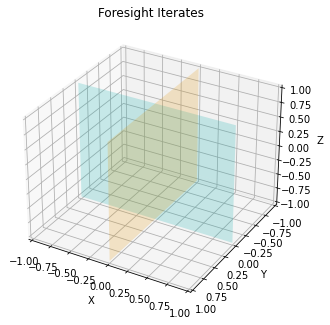

In [61]:
#f1,f2,f3,f4
diff = [np.array([1,1,2]),np.array([0,-1,0]),np.array([-1,+2,-1]),np.array([-2,0,1])]
x0 = np.array([-1,1,1])
sep = [h13D,h23D]

tstep = .11
T = 40

foresight_tstep = 0.00011
nskip = 10
foresight_depth = 1000

diamond = [np.array([.1,-.1,0.]),np.array([-.1,-.1,0.]),np.array([.1,.1,0.]),np.array([-.1,.1,0.])]
diamond_x0 = np.array([-1,-.01,0])

#x0 = diamond_x0*.1
#diff = diamond
niter = int(T/tstep)

PWS_foresight_anim = create_foresight_anim(T,
                                  diff,sep,x0,tstep,foresight_tstep, nskip,foresight_depth, niter)

#open('PWSeuler.gif')

HTML(PWS_foresight_anim.to_html5_video())

In [ ]:
X = list(islice(foresight_euler_gen(diff,sep,x0,tstep,foresight_tstep, nskip,foresight_depth), niter))
#print(which_quad)
which_quad =[]
for x in X:
    which_quad += [which_field(sep,x)]
    
fig,axs = plt.subplots(2,2,figsize = (15,15))
for i in [0,1]:
    for j in [0,1]:
        prop = prop_time(which_quad,(i,j))
        axs[i,j].plot(np.linspace(0,T,len(prop)),prop)
        axs[i,j].set_title('{} Quadrant, R{}'.format((i,j), 1+i+2*j))
        axs[i,j].set_ylim([0,1])
        axs[i,j].set_xlabel('Time')
        axs[i,j].set_ylabel('Proportional time in this quad')
fig.subplots_adjust(hspace=0.4,wspace = 0.4)


# Simplest Example

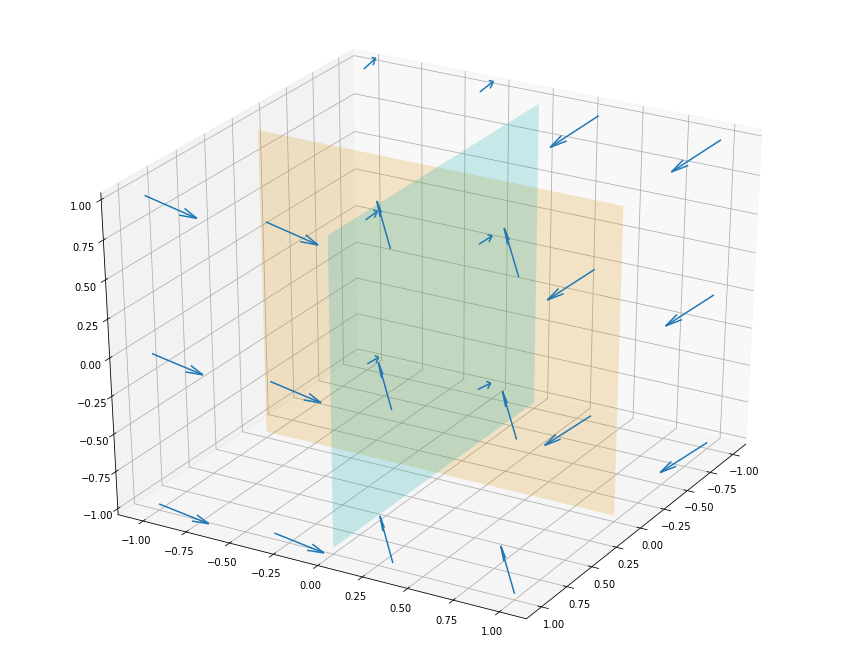

In [12]:
v = -1
#f1,f2,f3,f4
def diff():
    return [np.array([1,1,1]),np.array([1,-1,v]),np.array([-1,+1,v]),np.array([-1,-1,1])]
diff = diff()
#h1, h2
sep = [h13D,h23D]

def vector_field(diff,sep,d):
    fig = plt.figure(figsize=(15,12))
    ax = fig.gca(projection='3d')
    #30,30 is the default
    ax.view_init(elev=30, azim=30)

    h1,h2 = [*sep]
    f1,f2,f3,f4 = [*diff]
        
    x, y, z = np.linspace(-1,1,3), np.linspace(-1,1,d), np.linspace(-1,1,3)
    X, Y, Z = np.meshgrid(x,y,z)
    
    R1 = 1+0*X,1+0*Y,1+0*Z
    R1 = np.where((h1((X,Y,Z))<0) & (h2((X,Y,Z))<0), R1, 0)
    R2 = 1+0*X,-1+0*Y,-1+0*Z
    R2 = np.where((h1((X,Y,Z))<0) & (h2((X,Y,Z))>0), R2, 0)
    R3 = -1+0*X,1+0*Y,-1+0*Z
    R3 = np.where((h1((X,Y,Z))>0) & (h2((X,Y,Z))<0), R3, 0)
    R4 = -1+0*X,-1+0*Y,1+0*Z
    R4 = np.where((h1((X,Y,Z))>0) & (h2((X,Y,Z))>0), R4, 0)

    field = R1 + R2 + R3 + R4
    #print(field)
    #U, V, W = field#((X,Y,Z))
    
    ax.quiver(X, Y, Z, field[0],field[1],field[2], length=.3, normalize=True)
    
    xx, yy = np.meshgrid(range(-1,2), range(-1,2))
    ax.plot_surface(xx*0,yy,xx, alpha=0.2,color='orange')
    ax.plot_surface(xx, yy*0,yy, alpha=0.2,color = 'c')



    plt.show()

vector_field(diff,sep,4)



### Forward Euler

In [13]:
#PWS_euler_anim = create_euler_anim(T,clearing =True)

def euler_simplest(t,tstep,T,a=1,b=2,c=0):
    x_0 = np.array([a,b,c])

    return np.array(PWS_euler(diff,sep,tstep = tstep,x0=x_0,T=T)[0])

#HTML(PWS_euler_anim.to_html5_video())

### Bilinear

In [14]:
def bilinear_simplest(t,a=1,b=2,c=0):
    x_0 = np.array([a,b,c])
    
    if t>=0 and t< a:
        return x_0 + np.array([-t,-t,+t])
    elif t>= a and t<b:
        return np.array([0,b-t,a+c])
    elif t>=b:
        return np.array([0,0,a+c])

### Time Regularisation (Analytic and Approximation)

In [15]:
#def periodic_function(func, period, offset):
 #   return lambda x: func( ((x - offset) % period ) + offset)
    
    ## analytic solution from fusco and guglielmi paper

def time_reg_simplest(t,eps,a=1,b=2,c=0):
    x_0 = np.array([a,b,c])
    t1 = a
    t2 = b
    
    r = int((t2-t1)/(2*eps))
    delta = (t2-t1)/(2*eps) - r
    
    def x_oscil(t,eps):
    #z will also follow this pattern in the second regime
        while t>2*eps + t1:
            t -= 2*eps
        if t1<=t and t<=t1+eps:
            return -1/eps * (t-t1)*(t-t1-eps)
        elif t1+eps<=t and t<=t1+2*eps:
            return 1/eps * (t-t1-eps)*(t-t1-2*eps)

    def y_oscil(t,eps):
        while t>2*eps + t2:
            t -= 2*eps
        if t2<=t and t<=t2+eps:
            return -1/eps * (t-t2)*(t-t2-eps)
        elif t2+eps<=t and t<=t2+2*eps:
            return 1/eps * (t-t2-eps)*(t-t2-2*eps)
        
    def z_soln(t,eps):
        return x_oscil(t2,eps) + c + a + (2*(1-delta)-1)*(t - t2)
    
    if 0<=t and t<t1:
        return x_0 + np.array([-t,-t,t])
    elif t1<=t and t<t2:#tk negative sign in x_oscil
        return np.array([-x_oscil(t,eps),b-t,x_oscil(t,eps) + c + a])
    elif t2<=t:
        return np.array([-x_oscil(t,eps),-y_oscil(t,eps),z_soln(t,eps)])

# approximation for time delay

def time_delay_approx(eps,tstep,T,a=1,b=2,c=1):
    
    def values_before_zero(t):
        x = np.array([a-t,b-t,c+t])
        return x

    def integrand1(t,x):
        if callable(x):
            x = x(t)
        return 1/eps*(-1 * H(h1(x)) + (+1)*H(-h1(x)))

    def integrand2(t,x):
        if callable(x):
            x = x(t)
        return 1/eps*(-1 * H(h2(x)) + (+1)*H(-h2(x)))
    
    def integrand3(t,x):
        if callable(x):
            x = x(t)
        return 1/eps*(2*H(h1(x)) - 1)*(2*H(h2(x)) - 1)


    def model(Y, t):
        #print('t = ',t)
        x = Y(t)
        integral = [0,0,0]
        integrands =   [integrand1,integrand2,integrand3]
        for i, item in enumerate(Y(t)):
            func = integrands[i]
            integral[i] = quad(func,t-eps,t,args=(Y),limit = 200)[0]
        return integral
    
    n = int(T/tstep)
    
    tt = np.linspace(0, T, n)
    yy = ddeint(model, values_before_zero, tt)
    
    return tt,yy

euler z grad =  -0.9867606471697513
n= 94
delay z grad =  1.0
r+delta =  25.0
(2*(1-delta)-1) =  1.0


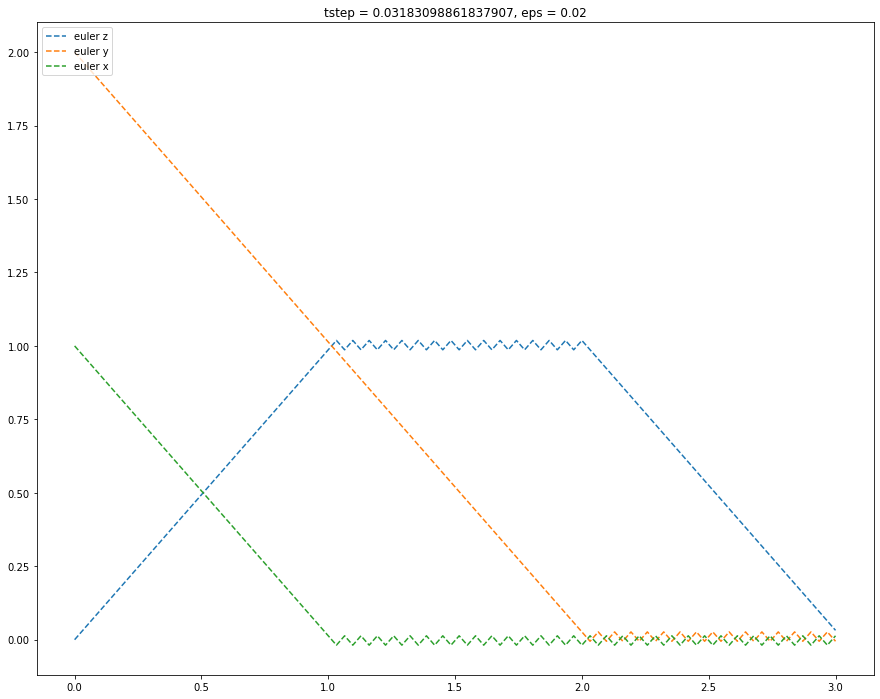

In [20]:
euler,bilinear,TR_analytic,TR_approx = 1,0,0,0

tstep = 1/(10*np.pi)#10**-5
#0.0001
T = 3
eps = 0.02

n = int(T/tstep)

vals = np.array(euler_simplest(t,tstep = tstep,T=T))

x_vals = vals[:,0]
y_vals = vals[:,1]
z_vals = vals[:,2]

plt.figure(figsize=(15,12))

if euler == True:
    plt.plot(np.linspace(0,T,n),z_vals,'--',label='euler z')
    plt.plot(np.linspace(0,T,n),y_vals,'--',label='euler y')
    plt.plot(np.linspace(0,T,n),x_vals,'--',label='euler x')

print('euler z grad = ', vals[-1,2] - vals[int(n*2/T),2])


B =[]
for t in np.linspace(0,T,n):
    B += [bilinear_simplest(t)]
B = np.array(B)
if bilinear == True:
    plt.plot(np.linspace(0,T,n),B[:,2],'-',label = 'bilinear z')
    plt.plot(np.linspace(0,T,n),B[:,1],'-',label = 'bilinear y')
    plt.plot(np.linspace(0,T,n),B[:,0],'-',label = 'bilinear x')

TR = []
for t in np.linspace(0,T,n):
    TR += [time_reg_simplest(t,eps)]
TR = np.array(TR)

if TR_analytic == True:
    plt.plot(np.linspace(0,T,n),TR[:,2],'-',label = 'delay z')
    plt.plot(np.linspace(0,T,n),TR[:,1],'-',label = 'delay y')
    plt.plot(np.linspace(0,T,n),TR[:,0],'-',label = 'delay x')


if TR_approx == True:
    
    tt,yy = time_delay_approx(eps,tstep,T)

    plt.plot(tt, yy[:,0],label='delay x approx')
    plt.plot(tt, yy[:,1],label='delay y approx')
    plt.plot(tt, yy[:,2],label='delay z approx')



plt.legend(loc="upper left")
plt.title("tstep = {}, eps = {}".format(tstep,eps))

print('n=',n)
print('delay z grad = ', TR[-1,2] - TR[int(n*2/T),2])

r = int(1/(2*eps))
delta = 1/(2*eps) - r

print('r+delta = ', 1/(2*eps))

print('(2*(1-delta)-1) = ', 2*(1-delta)-1)

### Proportion of time in each quadrant for forward euler and time regularisation methods

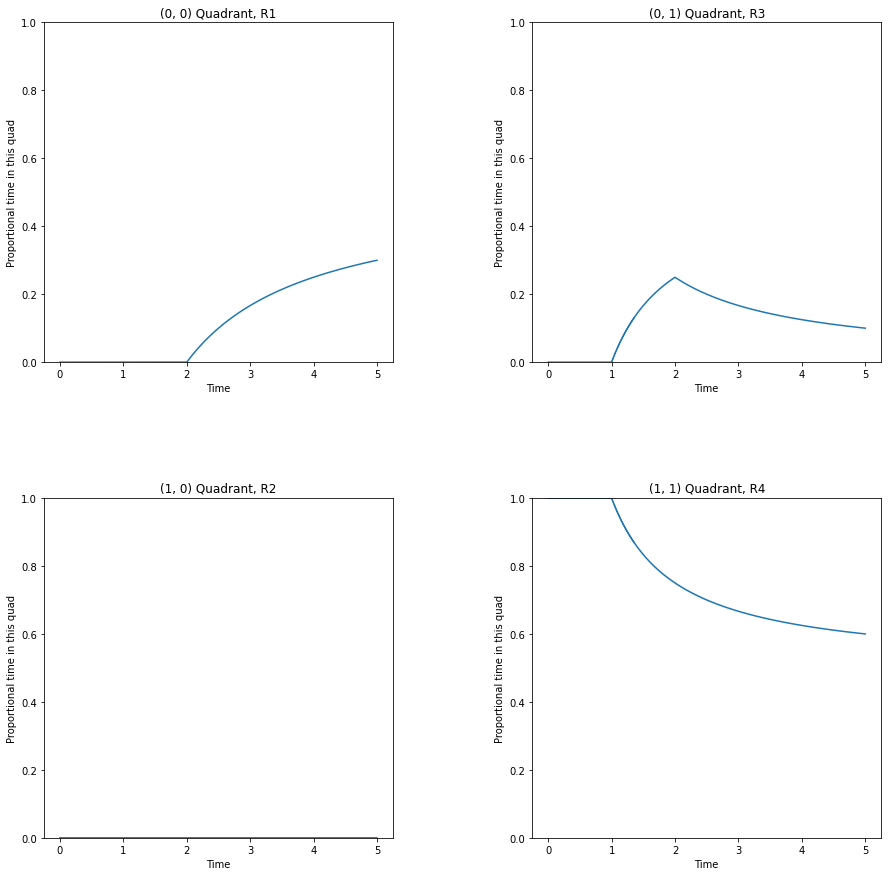

In [88]:
x_0 = np.array([1,2,0])

which_quad = PWS_euler(diff,sep,tstep = tstep,x0=x_0,T=T)[2]

fig,axs = plt.subplots(2,2,figsize = (15,15))
for i in [0,1]:
    for j in [0,1]:
        prop = prop_time(which_quad,(i,j))
        axs[i,j].plot(np.linspace(0,T,len(prop)),prop)
        axs[i,j].set_title('{} Quadrant, R{}'.format((i,j), 1+i+2*j))
        axs[i,j].set_ylim([0,1])
        axs[i,j].set_xlabel('Time')
        axs[i,j].set_ylabel('Proportional time in this quad')
fig.subplots_adjust(hspace=0.4,wspace = 0.4)